<a href="https://colab.research.google.com/github/Evans200png/Image_recognition/blob/main/Image_recogntion(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"evansonkimani","key":"54f207e4ce2b5256730bbf561e9a573f"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Download the TongPython cats-vs-dogs dataset
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 76% 165M/218M [00:00<00:00, 1.72GB/s]
100% 218M/218M [00:00<00:00, 1.04GB/s]


In [7]:
# Unzip into /content/cats-vs-dogs
!unzip -q cat-and-dog.zip -d cats-vs-dogs

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt

In [9]:
# Rescale pixels and reserve 20% for validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/cats-vs-dogs',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/cats-vs-dogs',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 8023 images belonging to 2 classes.
Found 2005 images belonging to 2 classes.


In [10]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
history1 = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_gen
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.7791 - loss: 0.5768 - val_accuracy: 0.7985 - val_loss: 0.5274
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.8003 - loss: 0.5126 - val_accuracy: 0.7985 - val_loss: 0.5126
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.7993 - loss: 0.5042 - val_accuracy: 0.7985 - val_loss: 0.5072
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7981 - loss: 0.4975 - val_accuracy: 0.7985 - val_loss: 0.5171
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.7941 - loss: 0.4946 - val_accuracy: 0.7985 - val_loss: 0.5147


In [12]:
# Unfreeze the base for fine-tuning
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen
)

Epoch 1/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 1100s 4s/step - accuracy: 0.8046 - loss: 0.4909 - val_accuracy: 0.7985 - val_loss: 0.5144
Epoch 2/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 1080s 4s/step - accuracy: 0.8025 - loss: 0.4831 - val_accuracy: 0.7985 - val_loss: 0.5153
Epoch 3/3
251/251 ━━━━━━━━━━━━━━━━━━━━ 1085s 4s/step - accuracy: 0.8030 - loss: 0.4713 - val_accuracy: 0.7985 - val_loss: 0.5162


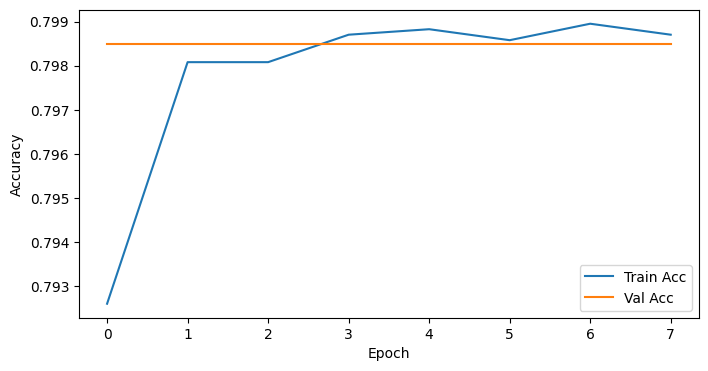

In [13]:
plt.figure(figsize=(8,4))
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Save only weights to avoid multi-input / BN mismatch later
model.save_weights('mobilenet_weights.weights.h5')
print("Saved weights to mobilenet_weights.weights.h5")

Saved weights to mobilenet_weights.weights.h5


In [15]:
model.save('mobilenet_cats_dogs.h5')
#loading
import tensorflow as tf
loaded_model = tf.keras.models.load_model('mobilenet_cats_dogs.h5')

63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 873ms/step


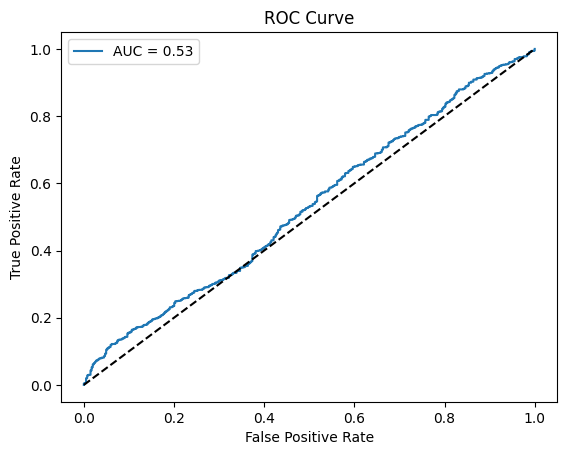

In [19]:
from sklearn.metrics import roc_curve,auc
y_pred_prob = loaded_model.predict(val_gen)
fpr, tpr, thresholds = roc_curve(val_gen.classes, y_pred_prob)

roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [20]:
from google.colab import files
uploaded = files.upload()  # Upload e.g. 'mycat.jpg'

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

img_path = '/content/dog1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = loaded_model.predict(img_array)
print("Predicted class:", "Dog" if prediction[0][0] > 0.5 else "Cat")

Saving dog1.jpg to dog1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
Predicted class: Dog


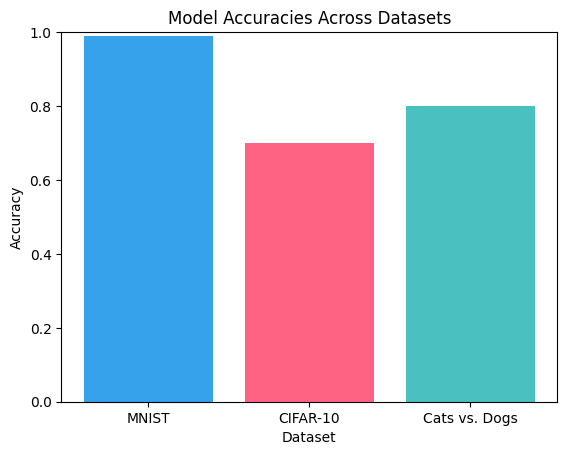

In [18]:
import matplotlib.pyplot as plt
datasets = ['MNIST', 'CIFAR-10', 'Cats vs. Dogs']
accuracies = [0.99, 0.70, 0.80]
plt.bar(datasets, accuracies, color=['#36A2EB', '#FF6384', '#4BC0C0'])
plt.title('Model Accuracies Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()